# Mobile tariff recommendation

You have at your disposal data on the behavior of customers who have already switched to these tariffs. You need to build a model for the classification problem that will select the appropriate tariff. Data preprocessing is not required - you have already done it.

Build the model with the largest possible *accuracy* value. To pass the project successfully, you need to bring the percentage of correct answers to at least 0.75. Check *accuracy* on the test set yourself.

## Data preparation

In [29]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier

In [30]:
# CONSTANTS
RANDOM_STATE = 654321

In [31]:
df = pd.read_csv('datasets/users_behavior.csv')

In [32]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [34]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


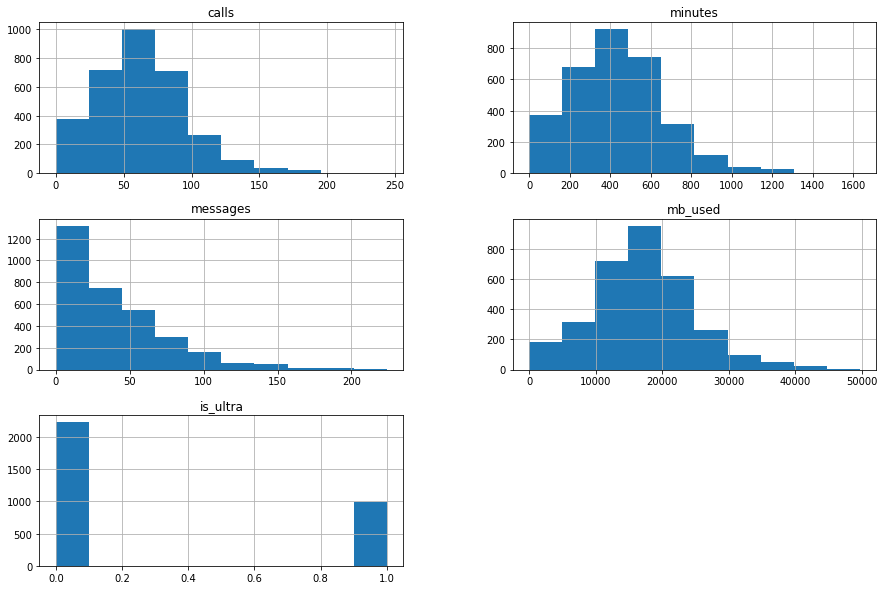

In [35]:
df.hist(figsize=(15,10))
plt.show()

As we can see, the data is already ready to use and train our models.

There is a noticeable disbalance between ultra tariff customers. The number of customers without an ultra tariff is more than 2 times as many as with an ultra tariff.

## Data separation

Let's split the data into 3 samples:
<li>Training - 60%</li>
<li>Validation - 20%</li>
<li>Test - 20%</li>

In [36]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [37]:
features_train, features_test, target_train, target_test = (
    train_test_split(features, target, test_size=0.4, random_state=RANDOM_STATE, stratify=target)
)

In [38]:
features_test, features_valid, target_test, target_valid = (
    train_test_split(features_test, target_test, test_size=0.5, random_state=RANDOM_STATE, stratify=target_test)
)

In [39]:
f'''Training: \
{features_train.shape[0]}, \
{target_train.shape[0]}, \
{round(features_train.shape[0]/df.shape[0]*100, 2)}%'''

'Training: 1928, 1928, 59.99%'

In [40]:
f'''Validation: \
{features_valid.shape[0]}, \
{target_valid.shape[0]}, \
{round(features_valid.shape[0]/df.shape[0]*100, 2)}%'''

'Validation: 643, 643, 20.01%'

In [41]:
f'''Test: \
{features_test.shape[0]}, \
{target_test.shape[0]}, \
{round(features_test.shape[0]/df.shape[0]*100, 2)}%'''

'Test: 643, 643, 20.01%'

Stratify check

In [42]:
target.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [43]:
target_train.value_counts(normalize=True)

0    0.693465
1    0.306535
Name: is_ultra, dtype: float64

In [44]:
target_test.value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

In [45]:
target_valid.value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

We see that the quantities are correct and the percentages are correct.

## Model training

To determine the most optimal model, we will train these models:
<li>Decision tree</li>
<li>Random forest</li>
<li>Logistic regression</li>

Let's train each model, look at the influence of hyperparameters on the quality metric - accuracy. The better we determine the right tariff for the client, the more profit we can potentially receive.

### Decision tree

Let's find the best hyperparameters for the decision tree:
<li>max_depth - from 1 to 10</li>
<li>splitters - best and random</li>
<li>criterion - gini and entropy</li>

In [12]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
best_tree_splitter = None
best_tree_criterion = None

# hyperparameters
num_tree_depths = 10
splitters = ['best', 'random']
tree_criterions = ['gini', 'entropy']

for spltr in splitters:
    for crit in tree_criterions:
        for depth in range(1,num_tree_depths+1):
            model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, splitter=spltr, criterion=crit )
            model_tree.fit(features_train, target_train)
            predictions_valid = model_tree.predict(features_valid)
            accuracy = accuracy_score(target_valid, predictions_valid)

            if accuracy > best_tree_result:
                best_tree_model = model_tree
                best_tree_result = accuracy
                best_tree_depth = depth
                best_tree_splitter = spltr
                best_tree_criterion = crit

tree_final_result = {'accuracy':round(best_tree_result*100,5),
                     'depth': best_tree_depth,
                     'splitter': best_tree_splitter,
                     'citerion': best_tree_criterion
                    }

In [13]:
tree_final_result

{'accuracy': 78.84914, 'depth': 9, 'splitter': 'random', 'citerion': 'entropy'}

We can see that the best tree comes out with accuracy = 78.85 with hyperparameters above. This is higher than the 75% we need, but we'll see if we can do better.

### Random forest

Let's find the best hyperparameters for the random forest:
<li>n_estimators - from 10 to 150, step=10</li>
<li>max_depth - from 4 to 10</li>
<li>criterion - gini and entropy</li>

In [14]:
best_forest_model = None
best_forest_result = 0
best_forest_size = 0
best_forest_tree_depth = 0
best_forest_criterion = None

# hyperparameters
num_forest_depths = range(10,151,10)
num_forest_tree_depths = range(4,11)
forest_criterions = ['gini', 'entropy']


for crit in forest_criterions:
    for size in num_forest_depths:
        for depth in num_forest_tree_depths:
            model_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=size, max_depth=depth, criterion=crit)
            model_forest.fit(features_train, target_train)
            predictions_valid = model_forest.predict(features_valid)
            accuracy = accuracy_score(target_valid, predictions_valid)
            
            if accuracy > best_forest_result:
                best_forest_model = model_forest
                best_forest_result = accuracy
                best_forest_size = size
                best_forest_tree_depth = depth
                best_forest_criterion = crit
            
forest_final_result = {'accuracy':round(best_forest_result*100,5),
                       'tree_depth': best_forest_tree_depth,
                       'forest_size': best_forest_size,
                       'criterion': best_forest_criterion
                      }

In [15]:
round(best_forest_result*100,5), best_forest_size, best_forest_tree_depth, best_forest_criterion

(81.493, 110, 10, 'gini')

In [16]:
forest_final_result

{'accuracy': 81.493, 'tree_depth': 10, 'forest_size': 110, 'criterion': 'gini'}

### Logistic regression

Let's find the best hyperparameters for the logistic regression:
<li>max_iter - from 100 to 5000, step=10</li>
<li>multi_class - auto, ovr, or multinomial</li>

In [17]:
best_linear_model = None
best_linear_result = 0
best_linear_iter = 0
best_linear_class = None

# hyperparameters
iters = range(100, 5001, 100)
multi_classes = ['auto', 'ovr', 'multinomial']


for clss in multi_classes:
    for itr in iters:
        model_linear = LogisticRegression(random_state=RANDOM_STATE, multi_class=clss, max_iter=itr)
        model_linear.fit(features_train, target_train)
        predictions_valid = model_linear.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
        if accuracy > best_linear_result:
            best_linear_model = model_linear
            best_linear_result = accuracy
            best_linear_iter = itr
            best_linear_class = clss

linear_final_result = {'accuracy':round(best_linear_result*100,5),
                       'max_iters': best_linear_iter,
                       'multi_classes': best_linear_class
                      }

In [18]:
linear_final_result

{'accuracy': 67.49611, 'max_iters': 100, 'multi_classes': 'auto'}

As we can see, here are the worst results - even less than 70%

**CONCLUSION**: at this stage, the random forest wins with a result above 80%.

## Check the best model

Let's test our best model, a random forest, on a test set

### Random forest

Let's combine the training set and the validation set, train our random forest with the best parameters and look at the accuracy after checking on the test set.

In [19]:
forest_final_result

{'accuracy': 81.493, 'tree_depth': 10, 'forest_size': 110, 'criterion': 'gini'}

In [46]:
features_train_valid = pd.concat([features_train, features_valid], ignore_index=True, sort=False)
target_train_valid = pd.concat([target_train, target_valid], ignore_index=True, sort=False)

In [47]:
target_train_valid.shape

(2571,)

In [48]:
features_train_valid.shape

(2571, 4)

In [23]:
final_model_forest = RandomForestClassifier(
    random_state=654321, n_estimators=110, max_depth=10, criterion='gini'
)
final_model_forest.fit(features_train_valid, target_train_valid)
final_predictions_test = final_model_forest.predict(features_test)
final_accuracy = accuracy_score(target_test, final_predictions_test)

In [24]:
round(final_accuracy*100,5)

82.58165

We can see that in the final test, our best selected model performed even better than in the first stages.

## Model adequacy 

Let's check if our model is adequte given that many of our clients still haven't switched tariffs.

In [49]:
dummy_model = DummyClassifier(strategy='constant', constant=0)
dummy_model.fit(features_train_valid, target_train_valid)
dummy_prediction = dummy_model.predict(features_test)
dummy_accuracy = accuracy_score(target_test, dummy_prediction)
print(f'Dummy accuracy: {dummy_accuracy}')

Dummy accuracy: 0.6936236391912908


In [51]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(features_train_valid, target_train_valid)
dummy_prediction = dummy_model.predict(features_test)
dummy_accuracy = accuracy_score(target_test, dummy_prediction)
print(f'Dummy accuracy: {dummy_accuracy}')

Dummy accuracy: 0.4681181959564541


Our random forest model is better than a dummy classifier.

## Conclusion

To conduct a study on our data, we first divided the data into 3 samples in the proportion of 60/20/20. We trained our model, we validated it, and then we tested it. We used these three selected models: decision tree, random forest, and linear regression.

During the training of each model, different (at least 2) hyperparameters were used in order to achieve the best result.
<br><br>

<li>Logistic regression showed the lowest results, its quality did not exceed 0.75</li>
<li>Decision tree showed a good result of 0.788</li>
<li>Random forest albeit being the slowest one showed the best accuracy of 0.815</li>

The models also outperform a dummy model classifier which predicts every client to be not on ultra tariff. 

Based on these findings the random forest is recommended. Its final accuracy is 0.8258